# Fractal Katenary Network

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import kan
import sklearn as skl
import torch
from mittag_leffler import ml

# Initialize Data

In [2]:
datafolder = "./datasets"

raw_data = []
volumes = []

# Read all csv files and append them in a list
for file in os.listdir(datafolder):
    volume_str, ext = file.split(".")
    if ext == "csv":
        volumes.append(volume_str.replace("_", ".").split("ml")[0])
        simple_df = pd.read_csv(os.path.join(datafolder, file), 
                                names=["x_raw", "y_raw"], decimal=",", delimiter=";")
        raw_data.append(simple_df)

In [3]:
# Sort the files depending on their name, related to the volume
volumes_float = [float(vol) for vol in volumes]
indices = np.argsort(volumes_float)
#np.array(volumes_float)[indices]

In [4]:
df = pd.concat(np.array(raw_data, dtype=object)[indices],
               keys=np.array(volumes_float)[indices])\
    .rename_axis(["volume", "id"])\
    .reset_index()
del df["id"]
df

,volume,x_raw,y_raw
0,0.0,-31.435066,31.556107
1,0.0,-31.100789,30.498769
2,0.0,-30.614569,29.815464
3,0.0,-30.249904,29.151295
4,0.0,-29.946017,28.416119
...,...,...,...
2116,27.0,31.108729,33.266380
2117,27.0,31.420994,33.769498
2118,27.0,31.777868,35.062518
2119,27.0,32.090134,35.593569


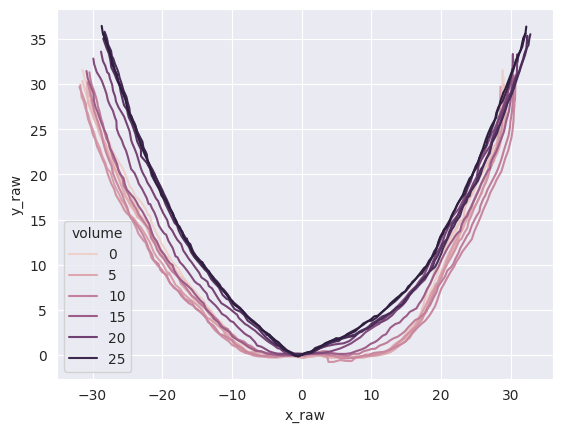

In [5]:
sns.lineplot(data=df, x="x_raw", y="y_raw", hue="volume")
plt.show()

In [6]:
df["x"] = df.groupby(["volume"])["x_raw"].apply(
    lambda x: 2 * (x - min(x)) / (max(x) - min(x)) - 1).reset_index(drop=True)
df["y"] = df.groupby(["volume"])["y_raw"].apply(
    lambda y: (y - max(y)) / (max(y) - min(y))).reset_index(drop=True)
df

,volume,x_raw,y_raw,x,y
0,0.0,-31.435066,31.556107,-1.000000,0.000000
1,0.0,-31.100789,30.498769,-0.988928,-0.033161
2,0.0,-30.614569,29.815464,-0.972823,-0.054592
3,0.0,-30.249904,29.151295,-0.960745,-0.075422
4,0.0,-29.946017,28.416119,-0.950679,-0.098479
...,...,...,...,...,...
2116,27.0,31.108729,33.266380,0.963484,-0.086339
2117,27.0,31.420994,33.769498,0.973737,-0.072580
2118,27.0,31.777868,35.062518,0.985454,-0.037216
2119,27.0,32.090134,35.593569,0.995706,-0.022693


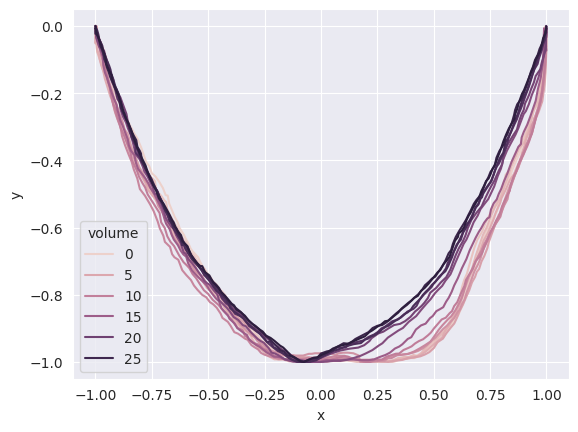

In [7]:
sns.lineplot(data=df, x="x", y="y", hue="volume")
plt.show()

In [8]:
# Create a dataset
X = df[["volume", "x"]].values
Y = df["y"].values

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

In [9]:
dataset = {}
dataset['train_input'], dataset['test_input'], dataset['train_label'], dataset['test_label'] = skl.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

dataset

{'train_input': tensor([[27.0000, -0.9272],
         [22.5000, -0.1526],
         [ 7.5000,  0.4702],
         ...,
         [15.0000, -0.5890],
         [18.0000, -0.2927],
         [ 9.0000, -0.3839]]),
 'test_input': tensor([[ 2.5500e+01, -7.7659e-01],
         [ 1.9500e+01,  7.6997e-01],
         [ 3.0000e+00, -8.0655e-01],
         [ 2.2500e+01,  5.4284e-01],
         [ 2.5500e+01, -6.3373e-01],
         [ 1.8000e+01,  2.2825e-01],
         [ 9.0000e+00,  8.0747e-01],
         [ 2.4000e+01, -6.6219e-01],
         [ 4.5000e+00,  5.3775e-01],
         [ 2.5500e+01, -8.4499e-01],
         [ 1.9500e+01, -4.8239e-01],
         [ 2.4000e+01,  6.4144e-01],
         [ 7.5000e+00,  7.3658e-01],
         [ 2.7000e+01,  5.7629e-01],
         [ 1.0500e+01, -1.4410e-02],
         [ 0.0000e+00, -2.1188e-01],
         [ 1.5000e+00, -2.9296e-02],
         [ 1.5000e+00,  6.0803e-01],
         [ 1.5000e+01, -9.6738e-01],
         [ 2.2500e+01,  5.2845e-01],
         [ 2.5500e+01, -6.1361e-01],
    

# KAN

In [10]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = kan.KAN(width=[2,3,1], grid=3, k=3, seed=0)

In [11]:
# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

train loss: 3.24e-01 | test loss: 3.14e-01 | reg: 1.14e+01 : 100%|██| 20/20 [00:20<00:00,  1.04s/it]


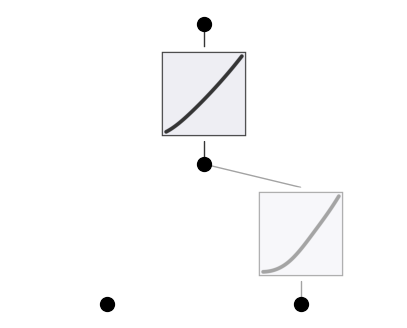

In [12]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [13]:
model.suggest_symbolic(0,0,0)

function , r2
cosh , 0.8474751114845276
tan , 0.8396831154823303
sin , 0.7085259556770325
x^4 , 0.6843776106834412
tanh , 0.5063223838806152


('cosh',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.8474751114845276)

In [14]:
model.suggest_symbolic(0,1,0)

function , r2
gaussian , 0.9999065399169922
sin , 0.9998895525932312
tanh , 0.9993617534637451
sigmoid , 0.9993590116500854
arctan , 0.9987803101539612


('gaussian',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9999065399169922)

In [15]:
model.suggest_symbolic(1,0,0)

function , r2
sin , 0.9999571442604065
gaussian , 0.999936044216156
tanh , 0.9999343752861023
sigmoid , 0.999934196472168
arctan , 0.9999157786369324


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9999571442604065)

In [82]:
model.suggest_symbolic(1,0,0,topk=15)

function , r2
x^4 , 0.9999998807907104
cosh , 0.9999992847442627
tanh , 0.9999988675117493
x^3 , 0.9999987483024597
arctan , 0.9999983310699463
sigmoid , 0.9999963641166687
gaussian , 0.9999955296516418
exp , 0.9999892711639404
1/x^4 , 0.9999702572822571
x^2 , 0.9999681115150452
1/x^3 , 0.9999624490737915
1/x^2 , 0.9999590516090393
sin , 0.9999489188194275
tan , 0.9999393224716187
1/x , 0.9999390840530396


('x^4',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9999998807907104)

train loss: 3.13e-01 | test loss: 3.04e-01 | reg: 7.11e-01 : 100%|██| 20/20 [00:04<00:00,  4.02it/s]


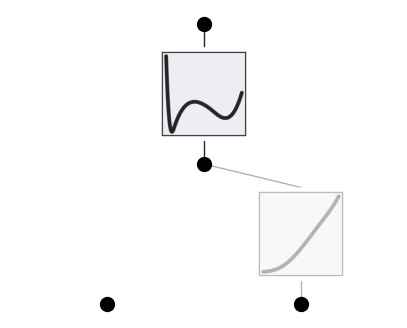

In [83]:
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

In [84]:
model.suggest_symbolic(0,0,0)
model.suggest_symbolic(0,1,0)
model.suggest_symbolic(1,0,0)

function , r2
sin , 0.9916107058525085
tanh , 0.9857191443443298
sigmoid , 0.9854857921600342
gaussian , 0.9845893979072571
arctan , 0.9825063347816467
function , r2
gaussian , 0.9996997714042664
sin , 0.9996587634086609
tanh , 0.9990261197090149
sigmoid , 0.9990260601043701
arctan , 0.9984593987464905
function , r2
1/x^4 , 0.45161762833595276
1/x^3 , 0.437497615814209
1/x^2 , 0.4084552526473999
tan , 0.32613614201545715
1/x , 0.32365456223487854


('1/x^4',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.45161762833595276)

In [85]:
model.auto_symbolic()

fixing (0,0,0) with sin, r2=0.9916107058525085
fixing (0,1,0) with gaussian, r2=0.9996997714042664
fixing (1,0,0) with 1/x^4, r2=0.45161762833595276


train loss: 3.13e-01 | test loss: 3.04e-01 | reg: 7.21e-01 : 100%|██| 20/20 [00:02<00:00,  9.57it/s]


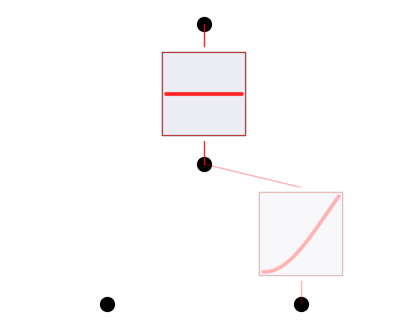

In [86]:
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

In [87]:
# obtaining symbolic formula
formula, variables = model.symbolic_formula()
formula[0]

-0.62

In [88]:
# if you want to rename your variables, you could use the "var" argument
formula, variables = model.symbolic_formula(var=['\\alpha','y'])
formula[0]

-0.62

In [89]:
# one can even postprocess the formula (e.g., taking derivatives)
from sympy import *
diff(formula[0], variables[0])

0

train loss: 3.13e-01 | test loss: 3.04e-01 | reg: 7.21e-01 : 100%|██| 20/20 [00:01<00:00, 12.15it/s]


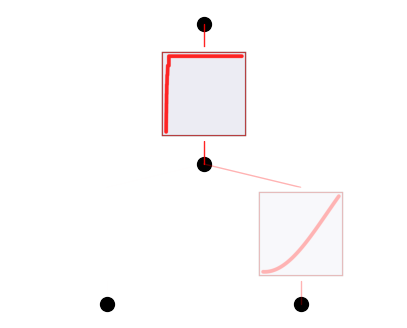

In [90]:
# this loss is stuck at around 1e-3 RMSE, which is good, but not machine precision.
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

In [42]:
# initialize a more fine-grained KAN with G=10
model2 = kan.KAN(width=[2,1,1], grid=10, k=3)
# initialize model2 from model
model2.initialize_from_another_model(model, dataset['train_input']);

In [43]:
model2.train(dataset, opt="LBFGS", steps=20);

train loss: 3.13e-01 | test loss: 3.04e-01 | reg: 2.87e-01 : 100%|██| 20/20 [00:05<00:00,  3.69it/s]


In [91]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = kan.KAN(width=[2,5,1], grid=grids[i], k=k)
    if i != 0:
        model = kan.KAN(width=[2,5,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

train loss: 3.13e-01 | test loss: 3.04e-01 | reg: 1.11e+01 : 100%|██| 50/50 [00:19<00:00,  2.60it/s]
train loss: 3.13e-01 | test loss: 3.04e-01 | reg: 1.11e+01 : 100%|██| 50/50 [00:10<00:00,  4.77it/s]
train loss: 3.13e-01 | test loss: 3.04e-01 | reg: 1.11e+01 : 100%|██| 50/50 [00:13<00:00,  3.57it/s]
train loss: 3.13e-01 | test loss: 3.04e-01 | reg: 1.10e+01 : 100%|██| 50/50 [00:43<00:00,  1.14it/s]
train loss: 3.13e-01 | test loss: 3.04e-01 | reg: 1.07e+01 : 100%|██| 50/50 [00:47<00:00,  1.04it/s]


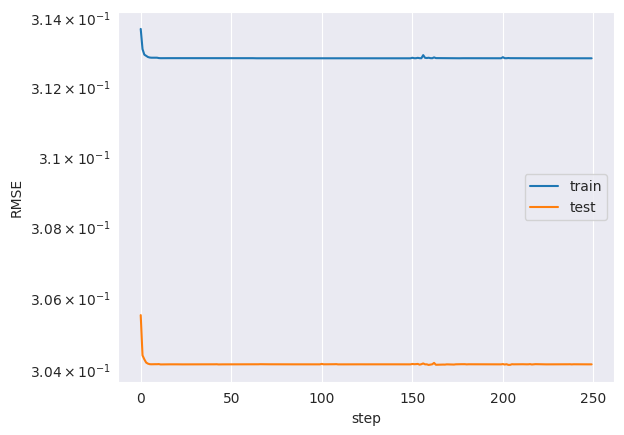

In [92]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

## test 3


In [16]:
model = kan.KAN(width=[2,5,1], grid=20, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

train loss: 3.15e-01 | test loss: 3.05e-01 | reg: 3.00e+01 : 100%|██| 20/20 [00:16<00:00,  1.21it/s]


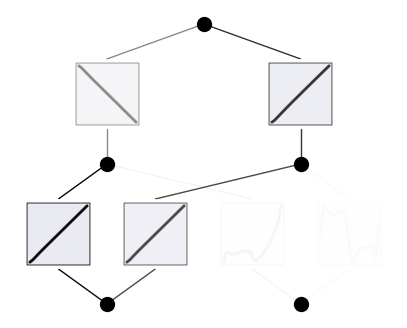

In [17]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [18]:
model.suggest_symbolic(0,0,0)

function , r2
abs , 0.9999595880508423
tan , 0.9999592304229736
sin , 0.9999591708183289
cosh , 0.9999591112136841
1/x^2 , 0.9999591112136841


('abs',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9999595880508423)

In [19]:
kan.SYMBOLIC_LIB.keys()

dict_keys(['x', 'x^2', 'x^3', 'x^4', '1/x', '1/x^2', '1/x^3', '1/x^4', 'sqrt', '1/sqrt(x)', 'exp', 'log', 'abs', 'sin', 'tan', 'tanh', 'sigmoid', 'sgn', 'arcsin', 'arctan', 'arctanh', '0', 'gaussian', 'cosh'])

In [20]:
def ml_torch(x):
    return torch.tensor(ml(x, 2, 2 + 0.5), dtype=np.float64)

In [21]:
kan.add_symbolic('ML', ml_torch)

In [22]:
model.suggest_symbolic(0,0,0)

KeyboardInterrupt: 

In [ ]:
model.train(dataset, opt="LBFGS", steps=20);

In [ ]:
model.plot()

In [ ]:
model.suggest_symbolic(0,0,0,a_range=(-40,40))